## Capstone Project - The Battle of Neighborhoods
### Introduction
Toronto is a large and ethnically diverse metropolis, with a high demand for foods from different cultures. For example, in Toronto there are restaurants belonging to different cuisines like French, Japanese, Indian, Mexican, etc. Moreover, since it is the financial capital of Canada, the city receives business people and tourists from all over the globe and they can visit many boroughs, as business and touristic attractions are widespread in Toronto.

A famous French chef selected to open his new gourmet restaurant in Toronto, since in a big and important financial city like Toronto a gourmet restaurant may proper and attract high spenders. He, as the stakeholder, asked our company for the best neighborhood to open his restaurant. He explained that the neighborhood should have a high demand for French cuisine and should have an opportunity for a top restaurant to prosper. Since most boroughs of Toronto already have many restaurants and a high competition between them, it is highly important to open a new restaurant in a location that provides an advantage against competitors.

My boss asked our team to answer the question: "Which neighborhood in Toronto is the best place to open a new top French restaurant?"

### Data
Since our stakeholder is looking to open up a French restaurant in Toronto, we will use and merge data from multiple resources, including:

1.Toronto neighborhoods data
2.Restaurant data
3.Venues data
#### Toronto neighborhood dataset
Data regarding Toronto neighborhoods were extracted from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, where we can extract the features regarding the postal codes, borough and neighborhoods. Then, we add to the dataset neighborhood latitude and longitude that we can extracted from http://cocl.us/Geospatial_data. Therefore, this dataset defines which neighborhoods Toronto has, where they are located and where we should look for French restaurants to discover high demand locations.

#### Restaurant data
In order to define neighborhoods with a high demand for French restaurants, we use the Foursquare API. From this API, we can extract the features: neighborhood, ID of the restaurant, name of the restaurant, number of Likes, rating and tips from French restaurants located in Toronto neighborhoods. Using this information, we can define neighborhoods with several French restaurants as having a high demand for French cuisine.

#### Venues data
After selecting a neighborhood based on high demand for a French restaurant, it is important to verify whether it provides a proper environment for a restaurant to thrive. Therefore, we collect information regarding venues in all neighborhoods and compare our selected neighborhood to all others to check for similarities. From this dataset we can extract the features name of the venue and venue category.

Using all datasets, we can analyze the data and select the best neighborhood to open a gourmet French restaurant in Toronto.

## Methodology
In this section, we describe the main components of our analysis. The Methodology section comprises four stages: 

1. Collection of Data

2.Exploration and Understanding of Data 

3.Data preparation and preprocessing 

4.Modeling 

5.Analysis 

### 1.Collection of Data

In [3]:
import pandas as pd
import numpy as np

!conda install -c conda-forge folium --yes 
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import json # library to handle JSON files
import requests # library to handle requests
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.3.1-py_0        conda-forge
    folium:          

In [4]:
!conda install -c conda-forge lxml --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lxml-4.4.1                 |   py36h7ec2d77_0         1.6 MB  conda-forge

The following packages will be UPDATED:

    lxml: 4.3.1-py36hefd8a0e_0 --> 4.4.1-py36h7ec2d77_0 conda-forge


lxml-4.4.1           | 1.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [5]:

# Read table from wikipedia to get the postal codes of Canada
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = df[0]

### 2. Exploration and Understanding of Data

In [6]:
# Drop rows with Borough = 'Not assigned'
df = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [7]:
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


### 3. Data preparation and preprocessing

In [8]:
df.sort_values('Postcode', inplace = True)
df.head()

,Postcode,Borough,Neighbourhood
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
22,M1C,Scarborough,Port Union
21,M1C,Scarborough,Rouge Hill
20,M1C,Scarborough,Highland Creek


In [9]:
# Replace Neighbourhood = 'Not assigned' with Borough and fix duplicated Postcodes

previous_idx = 10
missing_data = df['Neighbourhood'].isnull()
for i, val in df.iterrows():
    if missing_data[i]:
        df.loc[i, 'Neighbourhood'] = df.loc[i, 'Borough']
    if df.loc[i, 'Postcode'] == df.loc[previous_idx, 'Postcode']:
        df.loc[previous_idx, 'Neighbourhood'] = df.loc[previous_idx, 'Neighbourhood'] + ', ' + df.loc[i, 'Neighbourhood']
        df.drop([i], axis=0, inplace = True)
    else:
        previous_idx = i
        
df.reset_index(drop=True, inplace=True)

In [10]:
# Read geospace data
df_geospace = pd.read_csv('http://cocl.us/Geospatial_data')

In [11]:
df.rename(columns={"Postcode" : "PostalCode"}, inplace=True)

In [12]:
# Concatenate df and df_geospace to add latitude and longitude to postal codes
df_postalcode = pd.concat([df, df_geospace], join="inner", axis=1)
df_postalcode.drop('Postal Code', axis = 1, inplace=True)

In [13]:
df_postalcode.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Port Union, Rouge Hill, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 4. Modeling
Use geopy library to get the latitude and longitude values of Toronto.

In [14]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


### Create a dataframe with only Toronto boroughs

In [15]:
df_toronto = df_postalcode[df_postalcode['Borough'].str.contains("Toronto")]
df_toronto.reset_index(inplace=True)
df_toronto.head()

,index,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,37,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,41,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,43,M4M,East Toronto,Studio District,43.659526,-79.340923
4,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'ZZFL3RWKXZTITPQLXZFKY10Q1RWWK4WPGZQYLN3OWW4ZNNXU' # your Foursquare ID
CLIENT_SECRET = '0JGB5HH2BCUA0NJKTPA3HBTIEQEI12U4H15HTJI4D4X41YLS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
categoryId = '4bf58dd8d48988d10c941735' # Sushi restaurants

### Function to get top 100 French restaurants from all neighborhoods in Toronto

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            categoryId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                v['venue']['name'], 
                v['venue']['id'],
                v['venue']['categories'][0]['name']) for v in results])
        except IndexError:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Name', 
                  'ID',
                  'Venue Category']
    
    return(nearby_venues)

### Code to run the above function on each neighborhood and create a new dataframe called toronto_french_restaurants.

In [18]:
toronto_french_restaurants = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

### 5. Analysis

### Let's plot a graph to verify the amount of French restaurants in each neighborhood

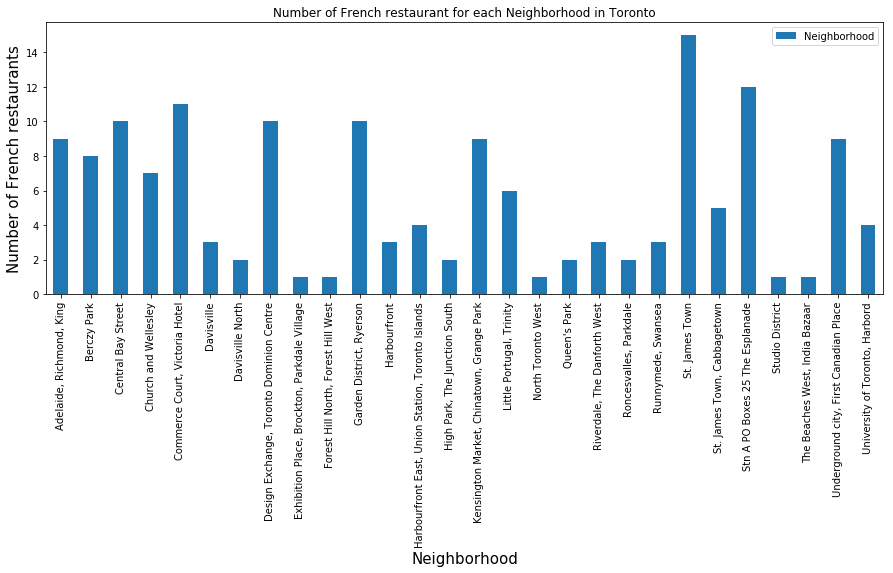

In [19]:
plt.figure(figsize=(15,5))
plt.title('Number of French restaurant for each Neighborhood in Toronto')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Number of French restaurants', fontsize=15)
toronto_french_restaurants.groupby('Neighborhood')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()


In [20]:
toronto_restaurants_count = toronto_french_restaurants.groupby('Neighborhood')['Neighborhood'].count()
neighborhood_top6 = toronto_restaurants_count[toronto_restaurants_count > 10].to_frame().index.to_list()
neighborhood_top6

['Commerce Court, Victoria Hotel',
 'St. James Town',
 'Stn A PO Boxes 25 The Esplanade']

As it is possible to observe there are 4 neighborhoods with more than 10 French restaurants: 'Church and Wellesley', 'Commerce Court, Victoria Hotel', 'King, Adelaide, Richmond', 'Toronto Dominion Centre, Design Exchange' and 'Underground city, First Canadian Place'
Considering that these neighborhoods have a high demand for French restaurants, we will further analyze them.
Let's get the ratings for each French restaurant in these 4 neighborhoods

In [21]:
# Get restaurants in these neighboorhodds
french_restaurants_top6neigh = toronto_french_restaurants[toronto_french_restaurants['Neighborhood'].str.match('|'.join(neighborhood_top6))]

### First we should define a function to get restaurants details from Foursquare

In [22]:
def get_restaurant_details(restaurant_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            restaurant_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get data
    results = requests.get(url).json()
    restaurant_data = results['response']['venue']
    
    restaurant_details = []
    try:
        restaurant_id = restaurant_data['id']
        restaurant_name = restaurant_data['name']
        restaurant_likes = restaurant_data['likes']['count']
        restaurant_rating = restaurant_data['rating']
        restaurant_tips = restaurant_data['tips']['count']
        restaurant_details.append([restaurant_id, restaurant_name, restaurant_likes, restaurant_rating, restaurant_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(restaurant_details,columns=column_names)
    return df

In [23]:
french_restaurants_details = pd.DataFrame(columns=['Neighborhood', 'ID','Name','Likes','Rating','Tips'])

for row in french_restaurants_top6neigh.values.tolist():
    Neighborhood,Name,ID,category=row
    try:
        restaurant_details = get_restaurant_details(ID)
        id,name,likes,rating,tips = restaurant_details.values.tolist()[0]
        french_restaurants_details = french_restaurants_details.append({'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    except IndexError:
        print('No data available for id=',ID)
        # We will ignore restaurants with no available details

In [24]:
french_restaurants_details.head()

,Neighborhood,ID,Name,Likes,Rating,Tips
0,"St. James Town, Cabbagetown",4d08ecf80ead8cfabe8cf276,Merryberry Cafe + Bistro,15,8.2,11
1,"St. James Town, Cabbagetown",4b6c81a1f964a5207d3f2ce3,Daniel et Daniel Event Creation & Catering,5,6.8,10
2,"St. James Town, Cabbagetown",4b646a6ff964a5205cb12ae3,Cranberries,24,8.5,18
3,"St. James Town, Cabbagetown",4ad4c05ff964a5202df720e3,The Pear Tree,17,7.2,7
4,"St. James Town, Cabbagetown",4add3b20f964a520b16421e3,House on Parliament,188,8.9,90


Now, we should compute the mean rating for each neighborhood

In [25]:
french_restaurants_grouped = french_restaurants_details.groupby('Neighborhood').mean().reset_index()
french_restaurants_grouped

,Neighborhood,Rating
0,"Commerce Court, Victoria Hotel",7.181818
1,St. James Town,7.406667
2,"St. James Town, Cabbagetown",7.920000
3,Stn A PO Boxes 25 The Esplanade,7.000000


## Results
The neighborhood 'Stn A PO Boxes 25 The Esplanade' has the lowest rating, so it represents an oportunity for a top French restaurant to explore.
Let's compute how many restaurants with ratings above 7.5 these 4 neighborhoods have

In [26]:
french_restaurants_greater75 = french_restaurants_details[french_restaurants_details['Rating']>7.5]
french_restaurants_greater75.sort_values(by=['Neighborhood'])
french_75_count = french_restaurants_greater75.groupby('Neighborhood').count()
french_75_count.drop(['Name', 'Likes', 'Rating', 'Tips'], axis=1, inplace=True)
french_75_count.rename(columns={'ID':'Count'}, inplace=True)
french_75_count

,Count
Neighborhood,
"Commerce Court, Victoria Hotel",4
St. James Town,7
"St. James Town, Cabbagetown",3
Stn A PO Boxes 25 The Esplanade,3


The 'Stn A PO Boxes 25 The Esplanade' neighborhood that is the second in number of French restaurants, has the lowest number of high rated French restaurants and the lowest average rating.
Now, let's analyze how similar it is to the neighborhoods with high ratings. If it is similar then the chosen neighborhood provides a similar environment in comparison with the other high rated neighborhoods.
First we should define a function to collect its top 100 venues for all categories.¶

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]


In [30]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, Richmond, King",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,...,0.0,0.0,0.0,0.020000,0.0,0.0,0.010000,0.0,0.01,0.000000
1,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.0,0.00,0.000000
2,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.058824
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012195,0.0,...,0.0,0.0,0.0,0.012195,0.0,0.0,0.012195,0.0,0.00,0.012195
4,Christie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000


### Function that sorts the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

### Cluster Neighborhoods
Run k-means to cluster the neighborhood into 10 clusters

In [33]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 4, 0, 0, 0, 7, 0], dtype=int32)

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

In [35]:
# merge toronto_grouped with df_toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,index,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,37,M4E,East Toronto,The Beaches,43.676357,-79.293031,5,Trail,Pub,Health Food Store,Neighborhood,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio
1,41,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Furniture / Home Store,Bookstore,Ice Cream Shop,Yoga Studio,Dessert Shop,Diner,Caribbean Restaurant
2,42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Fast Food Restaurant,Park,Ice Cream Shop,Sandwich Place,Board Shop,Burger Joint,Burrito Place,Fish & Chips Shop,Italian Restaurant,Steakhouse
3,43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,American Restaurant,Bakery,Brewery,Italian Restaurant,Gastropub,Yoga Studio,Fish Market,Pet Store
4,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Lawyer,Bus Line,Swim School,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


### cluster 1

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Riverdale, The Danforth West",-79.352188,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Furniture / Home Store,Bookstore,Ice Cream Shop,Yoga Studio,Dessert Shop,Diner,Caribbean Restaurant
2,"The Beaches West, India Bazaar",-79.315572,0,Fast Food Restaurant,Park,Ice Cream Shop,Sandwich Place,Board Shop,Burger Joint,Burrito Place,Fish & Chips Shop,Italian Restaurant,Steakhouse
3,Studio District,-79.340923,0,Café,Coffee Shop,American Restaurant,Bakery,Brewery,Italian Restaurant,Gastropub,Yoga Studio,Fish Market,Pet Store
6,North Toronto West,-79.405678,0,Clothing Store,Coffee Shop,Yoga Studio,Grocery Store,Salon / Barbershop,Restaurant,Rental Car Location,Park,Mexican Restaurant,Metro Station
7,Davisville,-79.388790,0,Sandwich Place,Pizza Place,Dessert Shop,Italian Restaurant,Gym,Coffee Shop,Café,Sushi Restaurant,Fried Chicken Joint,Deli / Bodega
9,"South Hill, Summerhill West, Rathnelly, Forest...",-79.400049,0,Pub,Coffee Shop,Sports Bar,Liquor Store,Vietnamese Restaurant,Supermarket,Sushi Restaurant,Light Rail Station,American Restaurant,Pizza Place
11,"St. James Town, Cabbagetown",-79.367675,0,Restaurant,Coffee Shop,Café,Italian Restaurant,Pub,Bakery,Pizza Place,Pet Store,Gym / Fitness Center,Chinese Restaurant
12,Church and Wellesley,-79.383160,0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Fast Food Restaurant,Gym,Hotel,Café,Gastropub
13,Harbourfront,-79.360636,0,Coffee Shop,Bakery,Pub,Café,Park,Restaurant,Breakfast Spot,Mexican Restaurant,Theater,Yoga Studio
14,"Garden District, Ryerson",-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Ramen Restaurant,Diner,Bookstore,Bakery,Electronics Store


### cluster2

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Summerhill East, Moore Park",-79.383160,1,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
10,Rosedale,-79.377529,1,Park,Playground,Trail,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


### cluster3

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Roselawn,-79.416936,2,Ice Cream Shop,Garden,Yoga Studio,Dessert Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


### cluster4

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lawrence Park,-79.38879,3,Park,Lawyer,Bus Line,Swim School,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


### cluster5

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Christie,-79.422564,4,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Baby Store,Diner,Coffee Shop,Nightclub,Gas Station


### cluster6

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,-79.293031,5,Trail,Pub,Health Food Store,Neighborhood,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio


### cluster7

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Forest Hill North, Forest Hill West",-79.411307,6,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


### cluster8

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Davisville North,-79.390197,7,Gym,Sandwich Place,Department Store,Asian Restaurant,Hotel,Food & Drink Shop,Breakfast Spot,Park,Eastern European Restaurant,Dumpling Restaurant


### cluster9

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,"King and Spadina, Railway Lands, South Niagara...",-79.39442,8,Airport Service,Airport Lounge,Airport Terminal,Boutique,Plane,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Bar


### cluster10

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[3] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,"Roncesvalles, Parkdale",-79.456325,9,Gift Shop,Italian Restaurant,Dog Run,Bar,Breakfast Spot,Restaurant,Coffee Shop,Bookstore,Eastern European Restaurant,Cuban Restaurant


## Discussions
From all the neighborhoods in Toronto, only four have more than 10 French restaurants, which means that only four neighborhoods have a high demand for them. These neighborhoods are: 'Commerce Court, Victoria Hotel', 'St. James Town', 'Stn A PO Boxes 25 The Esplanade', 'Toronto Dominion Centre, Design Exchange'. After we calculated the average ratings for all French restaurants in these neighborhoods, we discovered that 'Stn A PO Boxes 25 The Esplanade' is the second in number of French restaurants (high demand), but the lowest average rating and the lowest number of high rated restaurants.

The neighborhood 'Stn A PO Boxes 25 The Esplanade' seems like a good candidate, and we should confirm if it is a good neighborhood to open a restaurant by comparing it to other neighborhoods. Results demonstrate that the four neighborhoods with the highest demand for French restaurants are similar and were clustered together in cluster 1. Therefore, 'Stn A PO Boxes 25 The Esplanade' that has a high demand and the lowest average rating for French restaurants among them, is the best neighborhood to open a gourmet French restaurant.

## Conclusions
The problem proposed by the stakeholder was solved using data science. He wanted to find out the best place in Toronto to open a gourmet French restaurant based on high demand and a neighborhood that provide a good opportunity for his restaurant to grow and expand. From all the neighborhoods in Toronto, the best one is 'Stn A PO Boxes 25 The Esplanade' because it still has room for a restaurant with high ratings.